In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Để thực hiện ứng dụng mô hình vào bộ dữ liệu, trước tiên nhóm tiến hành import các thư viện liên quan để sử dụng, trong đó bao gồm:
*   pandas - thư viện được sử dụng để xử lý và phân tích dữ liệu
*   torch - thư viện Machine Learning dựa trên GPU của Python, cung cấp các mô hình và thuật toán Machine Learning được tối ưu hóa cho GPU.
*   transformers -  thư viện cung cấp các mô hình Transformer bao gồm BERT, RoBERTa, v.v.

In [ ]:
import pandas as pd

In [ ]:
from os import path

root_path = '/content/gdrive/Shareddrives/PTDL WEB/Bài tập + Đồ án/Đồ án'
preprocessing_path = path.join(root_path, 'dataset', 'preprocessing')
pred_path = path.join(root_path, 'dataset', 'pred')
model_path = path.join(root_path, 'model')


!ls "$root_path"
!ls "$preprocessing_path"
!ls "$model_path"

 dataset   documentation   fix.docx   model  'slangs update.docx'  'slangs update.txt'	 src
clean_electric.csv  clean_fashion.csv  fashion.csv  fashion_v2.csv  fashion.xlsx
0.35_0.18148148148148147		0.7866666666666666_0.787426301192761
0.3516666666666667_0.18298808055898072	0.7916666666666666_0.7840022724018945
0.3983333333333333_0.22694080254270954	0.7983333333333333_0.7973833595650964
0.59_0.5149936476617732			0.7983333333333333_0.8013730862328813
0.7266666666666667_0.7268739044617716	0.8066666666666666_0.8060000208768472
0.7616666666666667_0.7587329220507657	0.815_0.8162543877318738
0.7766666666666666_0.7780473867969921	0.825_0.8268434214683358
0.78_0.7832663001150312			0.835_0.8374656534009067
0.7816666666666666_0.782705307327485	full
0.785_0.7863202417550244		full_v2


## Khởi tạo mô hình dự đoán với mô hình tốt nhất đã được huán luyện trên 3000 comments

In [ ]:
from torch import cuda
from transformers import pipeline

analyzer = pipeline("sentiment-analysis", model = path.join(model_path, '0.835_0.8374656534009067'), tokenizer = "vinai/phobert-base-v2", max_length = 256, truncation = True, device = 'cuda' if cuda.is_available() else 'cpu')

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

### Hàm chuyển đổi cảm xúc thành điểm

In [ ]:
label2id = {
    'negative': 1,
    'neutral': 3,
    'positive': 5
}

def pred_star(sents):
    sents_dataset = CustomDataset(sents)
    results = analyzer(sents_dataset, batch_size = 256)
    results = [label2id[i['label']] * i ['score'] for i in results]
    return results

In [ ]:
for domain in domains:
  print(domain)
  print()
  print(results_df[domain])
  print("=" * 50)
  results_df[domain].to_pickle(path.join(pred_path, domain + '.df'))

In [ ]:
fashion_df = pd.read_pickle(pred_path + "/fashion.df")
electric_df = pd.read_pickle(pred_path + "/electric.df")
print(fashion_df)
print()
print(electric_df)

###Gộp pred_rating_star theo sao của toàn ngành hàng thời trang

In [ ]:
expand_dict_fashion = {col: [] for col in ['itemid', 'rating_star', 'pred_rating_star']}

for itemid, row in fashion_df.iterrows():
    rating_stars = row['rating_star']
    pred_rating_stars = row['pred_rating_star']

    for real, pred in zip(rating_stars, pred_rating_stars):
      expand_dict_fashion['itemid'].append(itemid)
      expand_dict_fashion['rating_star'].append(real)
      expand_dict_fashion['pred_rating_star'].append(pred)

expand_dict_fashion = pd.DataFrame.from_dict(expand_dict_fashion)
expand_dict_fashion = expand_dict_fashion.drop(['itemid'], axis = 1)
expand_dict_fashion

,rating_star,pred_rating_star
0,1,0.973464
1,1,2.167251
2,1,2.414856
3,1,2.705494
4,1,0.966309
...,...,...
14298,5,4.478945
14299,5,4.905092
14300,5,4.892186
14301,5,4.918531


##Giá trị trung bình của pre_rating_star theo rating
Nếu |diff| > 0.2 (20% của 1 sao) thì không đáng tin cậy.

Giải thích: Vì không tính shipper vào trong các bình luận tiêu cực, cũng như thái độ của shop,.... mức sản phẩm tệ là 1 nhưng do bộ train không tính các yếu tố bên ngoài nên mức sản phẩm tệ có thể cao hơn (ở đây là 1.4)

In [ ]:
test_df_fashion = expand_dict_fashion.groupby('rating_star')['pred_rating_star'].agg('mean').reset_index()
test_df_fashion['diff'] = test_df_fashion['rating_star'] - test_df_fashion['pred_rating_star']

test_df_fashion

,rating_star,pred_rating_star,diff
0,1,1.406632,-0.406632
1,2,1.776956,0.223044
2,3,2.508299,0.491701
3,4,3.502930,0.497070
4,5,4.587066,0.412934


### Giá trị rating trung bình sau khi mô hình dự đoán theo sản phẩm

Tính lượt đánh giá trung bình của sản phẩm sau khi ứng dụng mô hình dự đoán

In [ ]:
fashion_df['mean_rating_star'] = fashion_df['rating_star'].apply(lambda x: sum(x)/len(x))
fashion_df['mean_pred_rating_star'] = fashion_df['pred_rating_star'].apply(lambda x: sum(x)/len(x))
fashion_df.reset_index(inplace=True)

fashion_df[['itemid','mean_rating_star','mean_pred_rating_star']]

,itemid,mean_rating_star,mean_pred_rating_star
0,1592182206,3.250591,3.055366
1,6888422353,3.000000,2.858173
2,7141012796,3.000000,2.703049
3,10656336686,3.329870,2.863737
4,11899586276,4.076923,3.576232
...,...,...,...
95,23970387156,3.459384,3.198934
96,23977850887,5.000000,4.915441
97,24350679767,4.833333,3.831141
98,25300462790,4.666667,3.467567


##Nhận xét biểu đồ

Nhóm thực hiện vẽ biểu đồ để trực quan hoá và thấy được sự chênh lệch trong rating thật và rating dự đoán trên ngành hàng thời trang. Biểu đồ cột thể hiện giá trị thực (rating_star), trong khi biểu đồ đường thể hiện giá trị dự đoán (pred_rating_star). Nhìn chung thì vẫn có một sự chênh lệch nhất định tại các điểm.

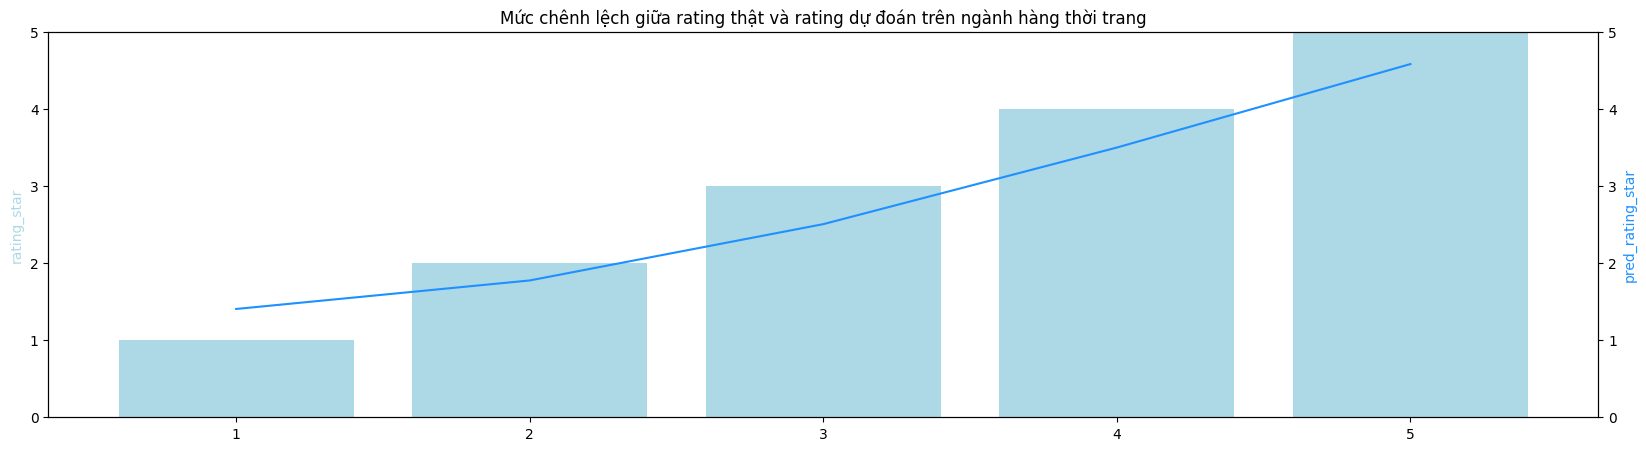

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.bar(range(1, 6), test_df_fashion['rating_star'], color='lightblue')
ax1.set_ylabel('rating_star', color='lightblue')
# Plotting on ax2 with the same y-axis limits as ax1
ax2 = ax1.twinx()
ax2.plot(range(1, 6), test_df_fashion['pred_rating_star'], color='dodgerblue')
ax2.set_ylabel('pred_rating_star', color='dodgerblue')
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)

plt.gcf().set_size_inches(20, 5)
plt.title("Mức chênh lệch giữa rating thật và rating dự đoán trên ngành hàng thời trang")
plt.show()

##Nhận xét biểu đồ
Dựa vào kết quả có thể thấy được rating thật và dự đoán gần sát nhau, do đó có thể thấy được các rating của ngành hàng thời trang đáng tin cậy. Tuy nhiên vẫn còn vài sản phẩm có mức độ rating chênh lệch

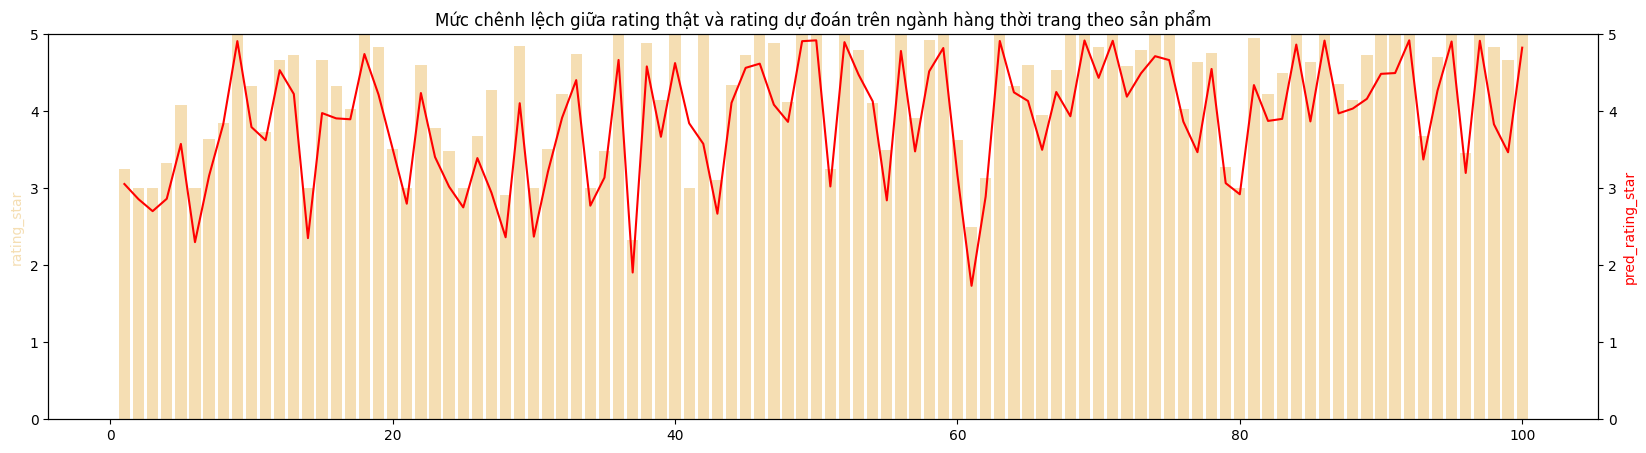

In [ ]:
fig, ax1 = plt.subplots()
ax1.bar(range(1,len(fashion_df)+1), fashion_df['mean_rating_star'], color='wheat')
ax1.set_ylabel('rating_star', color='wheat')
ax2 = ax1.twinx()
ax2.plot(range(1,len(fashion_df)+1), fashion_df['mean_pred_rating_star'], color='red')
ax2.set_ylabel('pred_rating_star', color='red')
plt.gcf().set_size_inches(20, 5)
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)
plt.title("Mức chênh lệch giữa rating thật và rating dự đoán trên ngành hàng thời trang theo sản phẩm")
plt.show()

##So sánh bình luận có lượt đánh giá chênh lệch nhất
Tại đây nhóm thực hiện phân tích sự chênh lệch giữa đánh giá thực với đánh giá được dự đoán, so sánh các bình luận có đánh giá chênh lệch nhất. Theo kết quả được đưa ra, đánh giá càng cao thì độ chênh lệch càng lớn. Trong đó ta thấy rằng các bình luận có đánh giá 4-5 sao nhưng nhận xét sản phẩm thì khá tệ, không đúng mô tả, sản phẩm giao sai hoặc các bình luận không liên quan để lấy xu. Điều này khiến cho các sản phẩm không được đánh giá đúng với chất lượng thực có.

In [ ]:
fashion_cmt_df = pd.read_csv(preprocessing_path + "/clean_fashion.csv")
fashion_cmt_df = fashion_cmt_df[['itemid','clean_cmt']]
fashion_cmt_df = fashion_cmt_df.groupby('itemid')['clean_cmt'].agg(list).reset_index()
fashion_cmt_df = pd.merge(fashion_df.reset_index(), fashion_cmt_df, on = 'itemid').drop(['mean_rating_star', 'mean_pred_rating_star'], axis = 1)
fashion_cmt_dict = {i: [] for i in ['rating_star', 'pred_rating_star', 'diff', 'clean_cmt']}

for index, row in fashion_cmt_df.iterrows():
    for real, pred, cmt in zip(row['rating_star'], row['pred_rating_star'], row['clean_cmt']):
        fashion_cmt_dict['rating_star'].append(real)
        fashion_cmt_dict['pred_rating_star'].append(pred)
        fashion_cmt_dict['diff'].append(real - pred)
        fashion_cmt_dict['clean_cmt'].append(cmt)

fashion_cmt_df = pd.DataFrame.from_dict(fashion_cmt_dict)
fashion_cmt_df = fashion_cmt_df.sort_values(by = 'diff', ascending = False).groupby('rating_star').agg(list)
for index, row in fashion_cmt_df.iterrows():
    print("REAL :", index)
    print()
    for i in range(5):
        print("PRED :", row['pred_rating_star'][i])
        print("DIFF :", row['diff'][i])
        print("CMT  :", row['clean_cmt'][i])
        print()
    print("=" * 10)

REAL : 1

PRED : 0.4958479106426239
DIFF : 0.5041520893573761
CMT  : màu_sắc đẹp đúng với mô_tả koooo chất_liệu vải xấu vdhhxbxjxjdjđhbdhdhdhfdjdhđbdhdjxdjđhdhưbdhbekwnệndjcbxjndkdkdndmdjdjdnjdhdhdbdbddjhdhdhdhdhhhbdjcndnzndhdhdhfcjndlwjwlsjxnixgxjsbhdjdndhdbbdbdbdbdbbdbdjdjdjdjdjjdjdjdjdjfbyxhsbxxudbxbvctvoososlxnlxj

PRED : 0.4982444643974304
DIFF : 0.5017555356025696
CMT  : chất_liệu tốt nhg cổ áo quá to không_thể để được chỉ may thì thừa cúc áo ở cổ thì vô_cùng kém chất_lượng

PRED : 0.4993308186531067
DIFF : 0.5006691813468933
CMT  : chất_liệu vải cứng màu sắc đen đúng với mô_tả một đúng màu nhưng bị rách một lỗ to

PRED : 0.5123303532600403
DIFF : 0.4876696467399597
CMT  : đúng với mô_tả sai lần đầu_tiên mình mua thấy đẹp nên mua cái nữa nhưng lần thứ hai vải xấu còn bị xanh đậm ở cuối ống_quần

PRED : 0.5196765661239624
DIFF : 0.4803234338760376
CMT  : màu_sắc be chất_liệu nỉ đúng với mô_tả không đúng áo mặc nóng vl mà mỏng lét nữa chứ áo quá rong tao m57 mặc như chùm cái mền sh

##Thử mô hình với outdomain - Đồ điện tử

In [ ]:
expand_dict_electric = {col: [] for col in ['itemid', 'rating_star', 'pred_rating_star']}

for itemid, row in electric_df.iterrows():
    rating_stars = row['rating_star']
    pred_rating_stars = row['pred_rating_star']

    for real, pred in zip(rating_stars, pred_rating_stars):
      expand_dict_electric['itemid'].append(itemid)
      expand_dict_electric['rating_star'].append(real)
      expand_dict_electric['pred_rating_star'].append(pred)

expand_dict_electric = pd.DataFrame.from_dict(expand_dict_electric)
expand_dict_electric = expand_dict_electric.drop(['itemid'], axis = 1)
expand_dict_electric

,rating_star,pred_rating_star
0,1,0.973545
1,1,0.551972
2,1,2.764914
3,1,0.968708
4,1,2.486613
...,...,...
24074,5,4.920068
24075,5,4.922615
24076,5,4.912963
24077,5,4.920229


##Giá trị trung bình của pre_rating_star theo rating
Nếu |diff| > 0.2 (20% của 1 sao) thì không đáng tin cậy

In [ ]:
test_df_electric = expand_dict_electric.groupby('rating_star')['pred_rating_star'].agg('mean').reset_index()
test_df_electric['diff'] = test_df_electric['rating_star'] - test_df_electric['pred_rating_star']
test_df_electric

,rating_star,pred_rating_star,diff
0,1,1.634349,-0.634349
1,2,2.000214,-0.000214
2,3,2.498909,0.501091
3,4,3.327552,0.672448
4,5,4.409100,0.590900


### Giá trị rating trung bình sau khi mô hình dự đoán theo sản phẩm


In [ ]:
electric_df['mean_rating_star'] = electric_df['rating_star'].apply(lambda x: sum(x)/len(x))
electric_df['mean_pred_rating_star'] = electric_df['pred_rating_star'].apply(lambda x: sum(x)/len(x))
electric_df.reset_index(inplace=True)
electric_df[['itemid','mean_rating_star','mean_pred_rating_star']]

,itemid,mean_rating_star,mean_pred_rating_star
0,1501977075,3.600649,3.301429
1,2071241387,3.728571,3.251279
2,2421374734,4.105882,3.787684
3,2450128642,3.010101,2.850799
4,2520156370,3.507937,3.128022
...,...,...,...
95,22913003497,3.971154,3.468030
96,22923102351,4.398148,3.830448
97,23304030881,3.961538,3.653429
98,23307034195,4.011628,3.632577


## Nhận xét biểu đồ

Nhóm thực hiện vẽ biểu đồ để trực quan hoá và thấy được sự chênh lệch trong rating thật và rating dự đoán trên ngành hàng thời trang. Biểu đồ cột thể hiện giá trị thực (rating_star), trong khi biểu đồ đường thể hiện giá trị dự đoán (pred_rating_star). Nhìn chung thì vẫn có một sự chênh lệch nhất định tại các điểm.

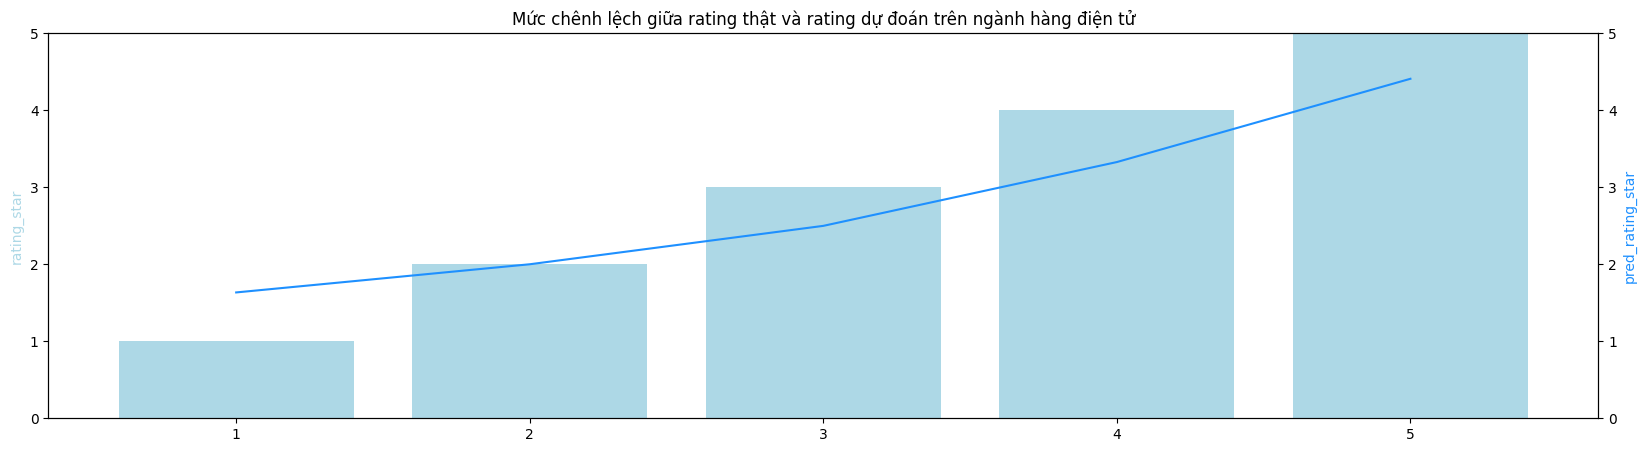

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.bar(range(1, 6), test_df_electric['rating_star'], color='lightblue')
ax1.set_ylabel('rating_star', color='lightblue')
# Plotting on ax2 with the same y-axis limits as ax1
ax2 = ax1.twinx()
ax2.plot(range(1, 6), test_df_electric['pred_rating_star'], color='dodgerblue')
ax2.set_ylabel('pred_rating_star', color='dodgerblue')
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)

plt.gcf().set_size_inches(20, 5)
plt.title("Mức chênh lệch giữa rating thật và rating dự đoán trên ngành hàng điện tử")
plt.show()

## Nhận xét biểu đồ

Dựa vào kết quả có thể thấy được rating thật và dự đoán gần sát nhau, do đó có thể thấy được các rating của ngành hàng thời trang đáng tin cậy

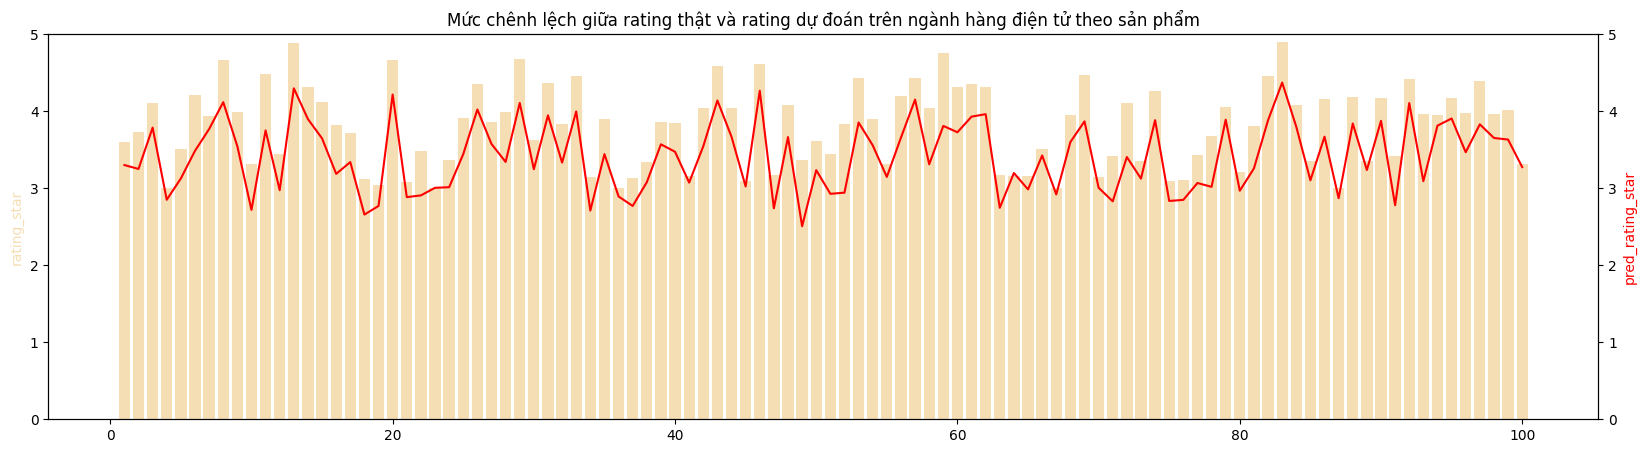

In [ ]:
fig, ax1 = plt.subplots()
ax1.bar(range(1,len(electric_df)+1), electric_df['mean_rating_star'], color='wheat')
ax1.set_ylabel('rating_star', color='wheat')
ax2 = ax1.twinx()
ax2.plot(range(1,len(electric_df)+1), electric_df['mean_pred_rating_star'], color='red')
ax2.set_ylabel('pred_rating_star', color='red')
plt.gcf().set_size_inches(20, 5)
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)
plt.title("Mức chênh lệch giữa rating thật và rating dự đoán trên ngành hàng điện tử theo sản phẩm")
plt.show()

##Nhận xét chênh lệch rating lớn nhất theo từng rating của domain đồ điện tử

Do có sự tương đồng trong các bình luận như "Chất lượng không tốt/không như mong đợi", "Mua về vứt luôn", "Không đáng tiền",... nên mô hình vẫn mang lại kết quả khá tốt đối với bộ dữ liệu out domain. Tuy nhiên, do đặc trưng của ngành hàng đồ điện tử, sẽ có các bình luận như "máy rè", "kính cường lực", "chất liệu silicon",... đây sẽ là các bình luận không xuất hiện trong bộ dữ liệu thời trang và dẫn đến những dự đoán sai trong kết quả sau khi dự đoán.

In [ ]:
electric_cmt_df = pd.read_csv(preprocessing_path + "/clean_electric.csv")
electric_cmt_df = electric_cmt_df[['itemid','clean_cmt']]
electric_cmt_df = electric_cmt_df.groupby('itemid')['clean_cmt'].agg(list).reset_index()
electric_cmt_df = pd.merge(electric_df.reset_index(), electric_cmt_df, on = 'itemid').drop(['mean_rating_star', 'mean_pred_rating_star'], axis = 1)
electric_cmt_dict = {i: [] for i in ['rating_star', 'pred_rating_star', 'diff', 'clean_cmt']}

for index, row in electric_cmt_df.iterrows():
    for real, pred, cmt in zip(row['rating_star'], row['pred_rating_star'], row['clean_cmt']):
        electric_cmt_dict['rating_star'].append(real)
        electric_cmt_dict['pred_rating_star'].append(pred)
        electric_cmt_dict['diff'].append(real - pred)
        electric_cmt_dict['clean_cmt'].append(cmt)

electric_cmt_df = pd.DataFrame.from_dict(electric_cmt_dict)
electric_cmt_df = electric_cmt_df.sort_values(by = 'diff', ascending = False).groupby('rating_star').agg(list)
for index, row in electric_cmt_df.iterrows():
    print("REAL :", index)
    print()
    for i in range(5):
        print("PRED :", row['pred_rating_star'][i])
        print("DIFF :", row['diff'][i])
        print("CMT  :", row['clean_cmt'][i])
        print()
    print("=" * 10)

REAL : 1

PRED : 0.4032250940799713
DIFF : 0.5967749059200287
CMT  : như lông

PRED : 0.4966873228549957
DIFF : 0.5033126771450043
CMT  : cảm_ứng rất khó khi lắp cái này vào

PRED : 0.4974696636199951
DIFF : 0.5025303363800049
CMT  : đã lưu_ý rõ một_mặt 40 một_mặt 44 vẫn giao sai ra hai mặt 44 làm_ăn chán đời

PRED : 0.4977503716945648
DIFF : 0.5022496283054352
CMT  : mua hàng trên shopee từ lúc shopee mới ra đến giờ mấy năm rồi chứ không ít chưa bao_giờ thấy một cái shop nào md như_vậy mua một lần thiếu hàng ok bỏ_qua mua lần hai vẫn giao thiếu bị ngu hay bị cố_tình hoàn tiền vào thằng shopee rút ra thằng ngân_hàng 11 nghìn tiền phí chứ free à

PRED : 0.4982835054397583
DIFF : 0.5017164945602417
CMT  : đơn hàng đặt mua cả tháng trời không thấy đâu mà bên vận_chuyển báo đã giao hàng thành_công không hiểu vn post làm_ăn kiểu gì đơn_vị vận_chuyển quá tồi không_thể chấp_nhận được

REAL : 2

PRED : 0.4993889033794403
DIFF : 1.5006110966205597
CMT  : chất_lượng sản_phẩm các nút cứng không n